In [1]:
import datastore

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

spot = datastore.getSpotPrice()

cons_gwh = datastore.getConsumptionGWh()

nuclear_finland_germany_mwh = datastore.getHourlyProduction_nuclear_EU()
germany_all = datastore.getHourlyProduction_Germany_all()

production_se1_mwh = datastore.getAllSE1ProductionMWh() 
production_se2_mwh = datastore.getAllSE2ProductionMWh()
production_se3_mwh = datastore.getAllSE3ProductionMWh()
production_se4_mwh = datastore.getAllSE4ProductionMWh()

otherData = datastore.getOtherNordPoolData()

hydroReservoirs = datastore.getWeeklyHydroReservs()

temp_pen = datastore.getDailyWeather()

# stationCap = datastore.getStationCap_forecast()
# transTo = datastore.getTransmissionCapTo_forecast()
# transFrom = datastore.getTransmissionCapFrom_forecast()

# productionCap = datastore.getProductionCap_forecast()


Missing values in Index(['spotPrice'], dtype='object') : 6
Missing values in Index(['ConsumptionSE1GWh', 'ConsumptionSE2GWh', 'ConsumptionSE3GWh',
       'ConsumptionSE4GWh'],
      dtype='object') : 68
Missing values in Index(['nucFI(MWh)', 'nucDE(MWh)'], dtype='object') : 874
Missing values in Index(['wind(Mwh)', 'solar(Mwh)', 'trm(Mwh)', 'biomass(Mwh)', 'coal(MWh)',
       'gas(MWh)', 'oil(MWh)', 'lignite(MWh)', 'nuc(MWh)', 'pump(MWh)',
       'other(MWh)', 'waste(MWh)'],
      dtype='object') : 1343
Missing values in Index(['waterSE1(MWh)', 'windSE1(MWh)', 'trmSE1MWh'], dtype='object') : 153
Missing values in Index(['waterSE2(MWh)', 'windSE2(MWh)', 'solSE2MWh', 'trmSE2MWh', 'OthSE2MWh'], dtype='object') : 347
Missing values in Index(['waterSE3(MWh)', 'windSE3(MWh)', 'nucSE3(MWh)', 'solSE3MWh',
       'trmSE3MWh', 'OthSE3MWh'],
      dtype='object') : 390
Missing values in Index(['waterSE4(MWh)', 'windSE4(MWh)', 'solSE4MWh', 'trmSE4MWh', 'OthSE4MWh'], dtype='object') : 358
Missing v

In [2]:
dataset = pd.concat([spot, cons_gwh, production_se1_mwh, production_se2_mwh, 
                                    production_se3_mwh, production_se4_mwh, temp_pen], axis=1)
# production_consumption = production_consumption.dropna()

dataset.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [36]:
import numpy as np


def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])
    data = np.array(data)
    labels = np.array(labels)
    print(data.shape)
    print(labels.shape)
    return data, labels

train_split = int(len(dataset) * 0.7)
validation_split = int(len(dataset) * 0.85)
test_split = len(dataset)



In [39]:
from sklearn.preprocessing import MinMaxScaler

past = 1
future = 0
step = 1

features = dataset.drop('spotPrice', axis=1)
target = dataset['spotPrice'].values.reshape(-1, 1)

featureScaler = MinMaxScaler(feature_range=(-1, 1))
targetScaler = MinMaxScaler(feature_range=(-1, 1))

x_train = featureScaler.fit_transform(features.values[:train_split])
y_train = targetScaler.fit_transform(target[:train_split])

x_val = featureScaler.transform(features.values[train_split:validation_split])
y_val = targetScaler.transform(target[train_split:validation_split])

x_test = featureScaler.transform(features.values[validation_split:test_split])
y_test = targetScaler.transform(target[validation_split:test_split])

x_train, y_train = multivariate_data(features.values, target, 0, 
                                     train_split, past, future, step, single_step=True)
x_val, y_val = multivariate_data(features.values, target, train_split, validation_split, 
                                 past, future, step, single_step=True)
x_test, y_test = multivariate_data(features.values, target, validation_split, test_split, 
                                   past, future, step, single_step=True)

(37832, 1, 27)
(37832, 1)
(8106, 1, 27)
(8106, 1)
(8107, 1, 27)
(8107, 1)


In [48]:
x_train.shape[-2:]

(1, 27)

In [40]:
import tensorflow as tf
import keras

model = keras.models.Sequential()

model.add(keras.layers.LSTM(64, input_shape=x_train.shape[-2:]))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                23552     
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 25665 (100.25 KB)
Trainable params: 25665 (100.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/15
2365/2365 [==============================] - 2s 874us/step - loss: 121200.7578 - mae: 199.2605 - val_loss: 2220428.7500 - val_mae: 939.8894
Epoch 2/15
2365/2365 [==============================] - 2s 867us/step - loss: 121774.0703 - mae: 203.5842 - val_loss: 2244584.2500 - val_mae: 932.7055
Epoch 3/15
2365/2365 [==============================] - 2s 835us/step - loss: 123299.0625 - mae: 204.2842 - val_loss: 2283190.5000 - val_mae: 937.4720
Epoch 4/15
2365/2365 [==============================] - 2s 923us/step - loss: 126651.0312 - mae: 203.9860 - val_loss: 2152807.2500 - val_mae: 910.2603
Epoch 5/15
2365/2365 [==============================] - 2s 843us/step - loss: 127858.3047 - mae: 209.9524 - val_loss: 2312218.5000 - val_mae: 945.3377
Epoch 6/15
2365/2365 [==============================] - 2s 865us/step - loss: 125243.2500 - mae: 202.8754 - val_loss: 2309174.5000 - val_mae: 946.9939
Epoch 7/15
2365/2365 [==============================] - 2s 834us/step - loss: 130470.5547 - ma

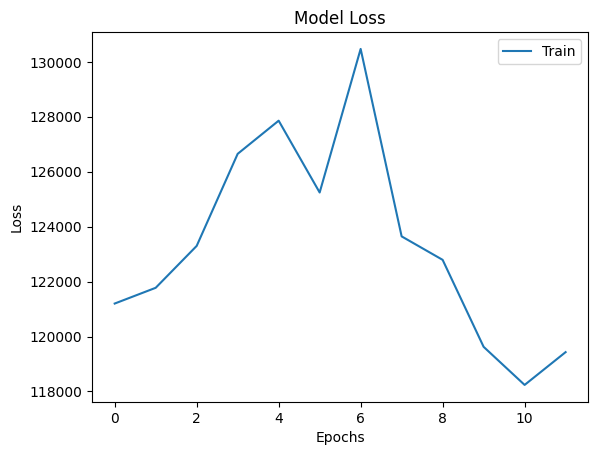

In [49]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

epochs = 15
batch_size = 16

log = model.fit(
    x_train, y_train, epochs=epochs, batch_size= 16, validation_data= (x_val, y_val),  callbacks=[callback]
)

plt.plot(log.history['loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train'])

254/254 [==============================] - 0s 543us/step


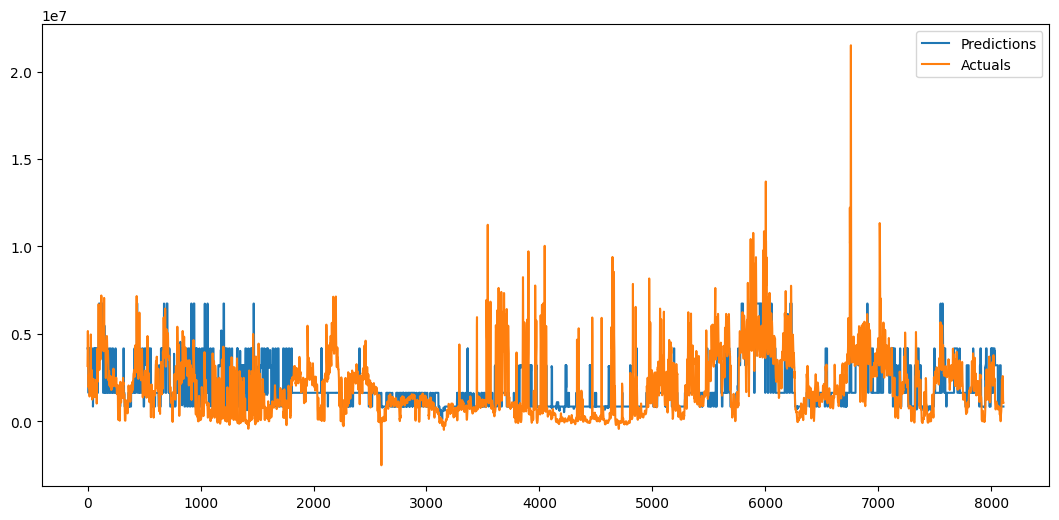

In [51]:
import matplotlib.pyplot as plt

predictions = targetScaler.inverse_transform(model.predict(x_test))
actuals = targetScaler.inverse_transform(y_test)

plt.figure(figsize=(13, 6))
plt.plot(predictions, label='Predictions')
plt.plot(actuals, label='Actuals')
plt.legend()
plt.show()

In [46]:
mae = tf.keras.losses.MeanAbsoluteError()
mae(actuals, predictions).numpy()

1062345.9